# [Feature Engineering](https://www.kaggle.com/code/ryanholbrook/what-is-feature-engineering)

By learn feature engineering, You'll know how to:

* determine which features are the most important with mutual information
* invent new features in several real-world problem domains
* encode high-cardinality categoricals with a target encoding
* create segmentation features with k-means clustering
* decompose a dataset's variation into features with principal component analysis

Benefits of feature engineering
* improve predictive performance
* reduce computational or data needs
* improve interpretability of the results

## A Guiding Principle of Feature Engineering

**Principle**
> Choose features that have relationship with target.

e.g. in linear models, choose or transform the features to make them have linear relationship to the target.

In house price predict linear model, we choose area=length * width as a squared feature. The linear model fits better than using length or width in this case.

### Example - Concrete Formulations

Given a task to predict a concrete's compressive strength from its formulation.

We can improve the predictive performance of a [<u>random forest model</u>](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) by adding a few synthetic features.



In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

concrete = pd.read_csv("data/concrete.csv")
concrete.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


#### Create baseline

Establish a baseline by training the model on the un-augmented dataset. This will help us determine whether our new features are actually useful.

By run the code below, we get an base line score: 8.232.

In [2]:
X = concrete.copy()
y = X.pop("CompressiveStrength")

# Train and score baseline model
baseline = RandomForestRegressor(
    criterion="absolute_error",   # measure the quality of a tree split. default=”squared_error”
    random_state=0                # Controls the randomnes of sampling
)

baseline_score = cross_val_score(
    baseline,   # estimator: model to fit test data
    X,          # features
    y,          # target
    cv=5,       # set cross-validation splitting strategy. KFold=5
    scoring="neg_mean_absolute_error",
)

baseline_score = -1 * baseline_score.mean()

print(f"MAE Baseline Score: {baseline_score:.4}")

MAE Baseline Score: 8.232


API reference:
* [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
* [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

#### Improve predictive performance

Since the ratio of ingredients usually is a better predictor than their absolute amounts. We create ratios of the features for CompressiveStrength prediction this time.

In [3]:
X = concrete.copy()
y = X.pop("CompressiveStrength")

# Create synthetic features
X["FCRatio"] = X["FineAggregate"] / X["CoarseAggregate"]
X["AggCmtRatio"] = (X["CoarseAggregate"] + X["FineAggregate"]) / X["Cement"]
X["WtrCmtRatio"] = X["Water"] / X["Cement"]

# Train and score model on dataset with additional ratio features
model = RandomForestRegressor(
    criterion="absolute_error", 
    random_state=0
)

score = cross_val_score(
    model, X, y, cv=5, scoring="neg_mean_absolute_error"
)
score = -1 * score.mean()

print(f"MAE Score with Ratio Features: {score:.4}")

MAE Score with Ratio Features: 7.948


The MAE score 7.948 < baseline 8.232. 

This is evidence that these new ratios exposed important information to the model that it wasn't detecting before.

## [Mutual Information (MI)](https://www.kaggle.com/code/ryanholbrook/mutual-information)
**Mutual Information (MI)** is a measure of the mutual dependence between **two random variables(a pair)** in terms of the information they provide about each other. In other words, it quantifies how much knowing one variable reduces uncertainty about the other.

Things to know when applying mutual information in feature selection:
* A variable with high mutual information with the target are often considered more relevant for modeling tasks, as it provides more predictive power.
* It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. MI can't detect interactions between features. It is a `univariate` metric. 
  * MI measures pairwise relationships: MI calculates the amount of information shared between pairs of variables. It does not directly consider interactions among multiple variables simultaneously. Therefore, it might not capture higher-order relationships or interactions involving more than two variables.
  * Nonlinear relationships: MI, in its basic form, measures linear relationships between variables. If the interactions between features are nonlinear, MI might not be able to capture them accurately.
* The actual usefulness of a feature depends on the model you use it with. A feature is only useful to the extent that its relationship with the target is one your model can learn. Just because a feature has a high MI score doesn't mean your model will be able to do anything with that information. You may need to transform the feature first to expose the association.

### Example - 1985 Automobiles

The task is predict the price (the target) of a car from features, such as `make`, `body_style`, `horsepower`, etc. 

In this example, we'll rank the features with mutual information and investigate the results by data visualization.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")

autos = pd.read_csv("data/autos.csv")
autos.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


The scikit-learn algorithm for MI treats `discrete` features differently from `continuous` features. 
* Float type variable is a continues feature, except
  * it has been divided into bins or categories and each float value corresponds to a specific bin or category.
* Categoricals (object or categorial dtype) can be treated as discrete by label encoding.

In [5]:
X = autos.copy()
y = X.pop("price")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

display(X.head())
display(discrete_features.head())

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg
0,3,0,0,0,2,0,0,0,88.6,168.8,...,4,130,0,3.47,2.68,9,111,5000,21,27
1,3,0,0,0,2,0,0,0,88.6,168.8,...,4,130,0,3.47,2.68,9,111,5000,21,27
2,1,0,0,0,2,1,0,0,94.5,171.2,...,6,152,0,2.68,3.47,9,154,5000,19,26
3,2,1,0,0,4,2,1,0,99.8,176.6,...,4,109,0,3.19,3.40,10,102,5500,24,30
4,2,1,0,0,4,2,2,0,99.4,176.6,...,5,136,0,3.19,3.40,8,115,5500,18,22


symboling       True
make            True
fuel_type       True
aspiration      True
num_of_doors    True
dtype: bool

Scikit-learn has two <u>mutual information metrics</u> in its `feature_selection module`: 
1. **real-valued** targets (`mutual_info_regression`)
2. **categorical** targets (`mutual_info_classif`)

Target `price` is real-valued. The next cell computes the MI scores for our features and wraps them up in a nice dataframe.

In [6]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    # Compute MI with mutual_info_regression() method
    mi_scores = mutual_info_regression(
        X,   # Feature dataframe.
        y,   # Target series
        discrete_features=discrete_features #
    )
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)

# show a few features with their MI scores (show 1 from every 3 rows)
mi_scores[::3]  

curb_weight          1.535805
highway_mpg          0.953521
length               0.608780
fuel_system          0.483333
stroke               0.383528
num_of_cylinders     0.331096
compression_ratio    0.133144
fuel_type            0.048139
Name: MI Scores, dtype: float64

And now a bar plot to make comparisions easier:

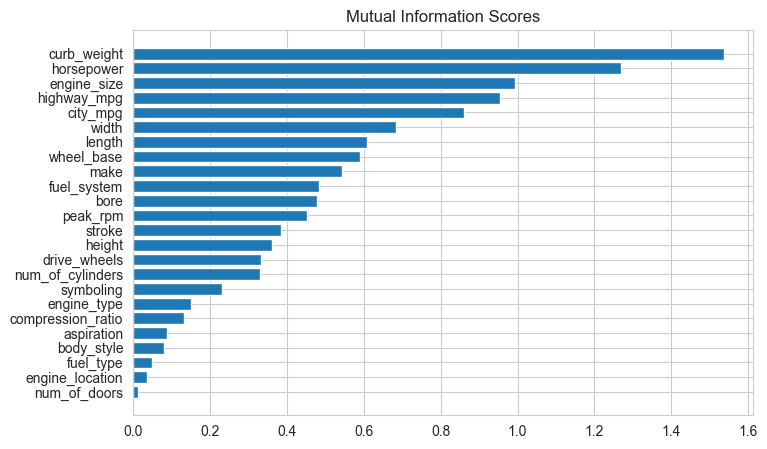

In [7]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

Data visualization is a great follow-up to a utility ranking. Let's take a closer look at a couple of these.

As we might expect, the high-scoring `curb_weight` feature exhibits a strong relationship with the target `price`.

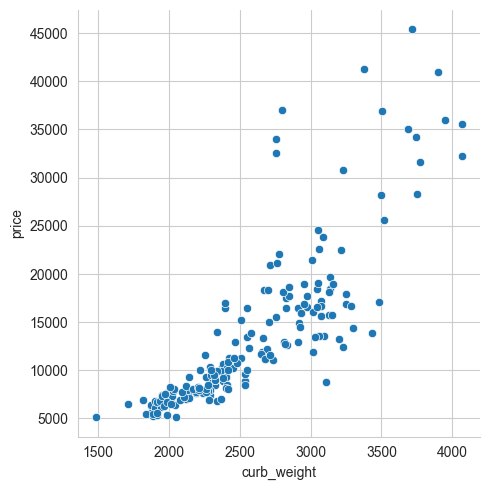

In [8]:
sns.relplot(
    data=autos, 
    x="curb_weight", 
    y="price",
    kind='scatter',   # the defaul and the same as sns.scatterplot()
);

The `fuel_type` feature has a fairly low MI score. Let's add 'fuel_type' category to see the plot. 

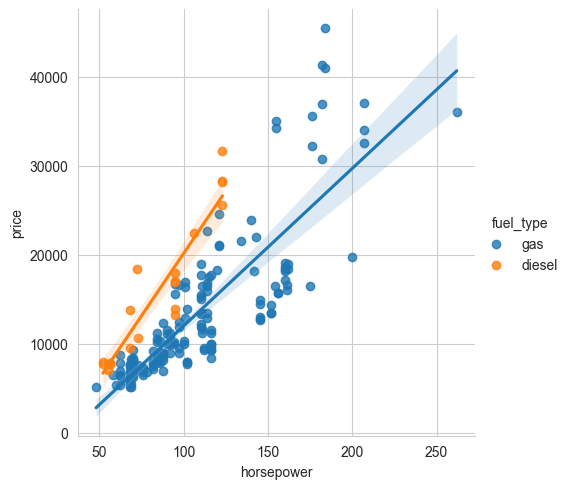

In [10]:
sns.lmplot(
    data=autos, 
    x="horsepower", 
    y="price", 
    hue="fuel_type"  # colored categorical on fuel_type column
);

The `fuel_type` clearly separates two price populations with different trends within the horsepower feature. It indicates that `fuel_type` contributes an interaction effect and might not be unimportant after all. 

Before deciding a feature is unimportant from its MI score, it's good to investigate any possible interaction effects -- domain knowledge can offer a lot of guidance.

## Creat features

### Mathematical Transforms

In Pandas, you can apply arithmetic operations to columns just as if they were ordinary numbers.

In [11]:
autos_trans = autos.copy()
autos_trans["stroke_ratio"] = autos.stroke / autos.bore

autos_trans[["stroke", "bore", "stroke_ratio"]].head()

,stroke,bore,stroke_ratio
0,2.68,3.47,0.772334
1,2.68,3.47,0.772334
2,3.47,2.68,1.294776
3,3.40,3.19,1.065831
4,3.40,3.19,1.065831


The more complicated a combination is, the more difficult for a model to learn. e.g.

In [12]:
autos["displacement"] = (
    np.pi * ((0.5 * autos.bore) ** 2) * autos.stroke * autos.num_of_cylinders
)

Data visualization can suggest transformations, often a "reshaping" of a feature through powers or logarithms. The distribution of `WindSpeed` in US Accidents is highly skewed, for instance. In this case the logarithm is effective at normalizing it:

In [13]:
accidents = pd.read_csv("data/accidents.csv")
accidents.head()

,Severity,StartTime,EndTime,StartLat,StartLng,Distance,Street,City,State,Zipcode,...,Crossing,GiveWay,Junction,NoExit,Railway,Roundabout,Station,Stop,TrafficCalming,TrafficSignal
0,2,2019-07-22 14:43:06,2019-07-22 16:22:19,34.789009,-82.483383,0.000,Highway 153,Greenville,SC,29611,...,False,False,False,False,False,False,False,False,False,False
1,2,2019-03-20 16:12:14,2019-03-20 16:41:05,40.998264,-76.650396,0.472,Continental Blvd,Danville,PA,17821,...,False,False,False,False,False,False,False,False,False,False
2,3,2018-12-12 14:19:18,2018-12-12 14:48:56,33.461292,-112.082001,0.000,I-10 W,Phoenix,AZ,85003,...,False,False,False,False,False,False,False,False,False,False
3,2,2018-03-09 08:02:11,2018-03-09 08:49:15,42.288445,-87.924911,0.000,Oak Spring Rd,Libertyville,IL,60048,...,False,False,False,False,False,False,False,False,False,False
4,2,2020-03-27 05:36:56,2020-03-27 06:36:48,36.229259,-86.594650,0.000,Saundersville Rd,Old Hickory,TN,37138,...,False,False,False,False,False,False,False,False,False,False


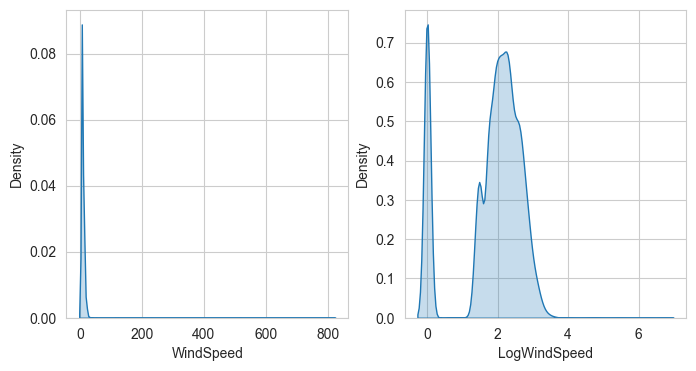

In [15]:
# If the feature has 0.0 values, use np.log1p (log(1+x)) instead of np.log
accidents["LogWindSpeed"] = accidents.WindSpeed.apply(np.log1p)

# Plot a comparison
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(accidents.WindSpeed, fill=True, ax=axs[0])
sns.kdeplot(accidents.LogWindSpeed, fill=True, ax=axs[1]);

### Counts

Features describing the presence or absence will be binary (1 for Present, 0 for Absent) or boolean (True or False). You can aggregate such features by creating a **count**. 

In Python, booleans can be added up just as if they were integers.

For instance, we will create a `count` of the total number of roadway objects(features) nearby the accidents using a sum method:

In [17]:
roadway_features = ["Amenity", "Bump", "Crossing", "GiveWay",
    "Junction", "NoExit", "Railway", "Roundabout", "Station", "Stop",
    "TrafficCalming", "TrafficSignal"]
accidents["RoadwayFeatures"] = accidents[roadway_features].sum(axis=1)

accidents[roadway_features + ["RoadwayFeatures"]].head(10)

,Amenity,Bump,Crossing,GiveWay,Junction,NoExit,Railway,Roundabout,Station,Stop,TrafficCalming,TrafficSignal,RoadwayFeatures
0,False,False,False,False,False,False,False,False,False,False,False,False,0
1,False,False,False,False,False,False,False,False,False,False,False,False,0
2,False,False,False,False,False,False,False,False,False,False,False,False,0
3,False,False,False,False,False,False,False,False,False,False,False,False,0
4,False,False,False,False,False,False,False,False,False,False,False,False,0
5,False,False,False,False,True,False,False,False,False,False,False,False,1
6,False,False,False,False,False,False,False,False,False,False,False,False,0
7,False,False,True,False,False,False,False,False,False,False,False,True,2
8,False,False,True,False,False,False,False,False,False,False,False,True,2
9,False,False,False,False,False,False,False,False,False,False,False,False,0


You could also use a dataframe's built-in methods to create boolean values. In the Concrete dataset are the amounts of components in a concrete formulation. Many formulations lack one or more components (that is, the component has a value of 0). This will count how many components are in a formulation with the dataframe's built-in greater-than `gt` method:

In [18]:
components = [ "Cement", "BlastFurnaceSlag", "FlyAsh", "Water",
               "Superplasticizer", "CoarseAggregate", "FineAggregate"]

# .gt(0) creates boolean vectors
concrete["Components"] = concrete[components].gt(0).sum(axis=1)

concrete[components + ["Components"]].head(10)

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Components
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,5
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,5
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,5
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,4


### Building-Up and Breaking-Down Features

#### Breaking down

Create two new features from a feature though str.split() method.

In [21]:
customer = pd.read_csv("data/customer.csv")

customer[["Type", "Level"]] = (  # Create two new features
    customer["Policy"]           # from the Policy feature
    .str                         # through the string accessor
    .split(" ", expand=True)     # by splitting on " "
                                 # and expanding the result into separate columns
)

customer[["Policy", "Type", "Level"]].head(10)

,Policy,Type,Level
0,Corporate L3,Corporate,L3
1,Personal L3,Personal,L3
2,Personal L3,Personal,L3
3,Corporate L2,Corporate,L2
4,Personal L1,Personal,L1
5,Personal L3,Personal,L3
6,Corporate L3,Corporate,L3
7,Corporate L3,Corporate,L3
8,Corporate L3,Corporate,L3
9,Special L2,Special,L2


#### Bring-up
You could also join simple features into a composed feature if you believe there was some interaction in the combination:

In [22]:
autos["make_and_style"] = autos["make"] + "_" + autos["body_style"]
autos[["make", "body_style", "make_and_style"]].head()

,make,body_style,make_and_style
0,alfa-romero,convertible,alfa-romero_convertible
1,alfa-romero,convertible,alfa-romero_convertible
2,alfa-romero,hatchback,alfa-romero_hatchback
3,audi,sedan,audi_sedan
4,audi,sedan,audi_sedan


There are a few other kinds of data we haven't talked about here 
  * For dates and times, see Parsing Dates from our [Data Cleaning](https://www.kaggle.com/code/alexisbcook/parsing-dates/tutorial) course.
  * For latitudes and longitudes, see our [Geospatial Analysis](https://www.kaggle.com/learn/geospatial-analysis) course.

### Group Transforms

**Group transforms** aggregate information across multiple rows grouped by some category. With it, you can create features like: "the average income of a state".

1. See the original dataset

In [25]:
customer[["State", "Income"]]

,State,Income
0,Washington,56274
1,Arizona,0
2,Nevada,48767
3,California,0
4,Washington,43836
...,...,...
9129,California,71941
9130,California,21604
9131,California,0
9132,California,21941


2. Create a new feature `"AverageIncome"` with group transform.

In [26]:
customer["AverageIncome"] = (
    customer.groupby("State")  # for each state
    ["Income"]                 # select the income
    .transform("mean")         # and compute its mean
)

customer[["State", "Income", "AverageIncome"]]

,State,Income,AverageIncome
0,Washington,56274,38122.733083
1,Arizona,0,37405.402231
2,Nevada,48767,38369.605442
3,California,0,37558.946667
4,Washington,43836,38122.733083
...,...,...,...
9129,California,71941,37558.946667
9130,California,21604,37558.946667
9131,California,0,37558.946667
9132,California,21941,37558.946667


The `mean` function is a built-in dataframe method. We pass it as a string to transform. Other handy methods include `max`, `min`, `median`, `var`, `std`, and `count`. 

Here's how you could calculate the frequency with which each state occurs in the dataset:

In [27]:
customer["StateFreq"] = (
    customer.groupby("State")
    ["State"]
    .transform("count")
    / customer.State.count()
)

customer[["State", "StateFreq"]].head(10)

,State,StateFreq
0,Washington,0.087366
1,Arizona,0.186446
2,Nevada,0.096562
3,California,0.344865
4,Washington,0.087366
5,Oregon,0.284760
6,Oregon,0.284760
7,Arizona,0.186446
8,Oregon,0.284760
9,Oregon,0.284760


If you're using training and validation splits, to preserve their independence, it's best to create a grouped feature on training set only and then join it to the validation set. We can use the validation set's merge method after creating a unique set of values with drop_duplicates on the training set:

In [28]:
# Create splits
df_train = customer.sample(frac=0.5)
df_valid = customer.drop(df_train.index)

# Create the average claim amount by coverage type, on the training set
df_train["AverageClaim"] = df_train.groupby("Coverage")["ClaimAmount"].transform("mean")

# Merge the values into the validation set
df_valid = df_valid.merge(
    df_train[["Coverage", "AverageClaim"]].drop_duplicates(),
    on="Coverage",
    how="left",
)

df_valid[["Coverage", "AverageClaim"]].head(10)

,Coverage,AverageClaim
0,Premium,661.118727
1,Basic,377.305299
2,Extended,485.941099
3,Basic,377.305299
4,Premium,661.118727
5,Basic,377.305299
6,Basic,377.305299
7,Basic,377.305299
8,Basic,377.305299
9,Premium,661.118727


### Tips on Creating Features
Keep in mind your model's strengths and weaknesses when creating features. Here are some guidelines:
* `Linear models` learn sums and differences naturally, but can't learn anything more complex.
* `Ratios` seem to be difficult for most models to learn. Ratio combinations often lead to some easy performance gains.
* `Linear models` and `neural networks` generally do better with normalized features.
  * `Neural networks` especially need features scaled to values not too far from 0.
  * `Tree-based models` (like random forests and XGBoost) can sometimes benefit from normalization, but usually much less so.
* `Tree models` can learn to approximate almost any combination of features, but when a combination is especially important they can still benefit from having it explicitly created, especially when data is limited.
* `Counts` are especially helpful for tree models, since these models don't have a natural way of aggregating information across many features at once.

## Clustering With K-Means

Unsupervised algorithms don't make use of a target; instead, their purpose is to learn some property of the data. You could think of an unsupervised algorithm as a "feature discovery" technique.

**Clustering** is to partition a dataset into subsets (or clusters). Data points within the same cluster are more similar to each other compared to those in other clusters.

### k-Means Clustering

K-means clustering is widely used in various applications, including customer segmentation, image compression, anomaly detection, and document clustering.

It is used for partitioning a dataset into a set of K distinct, non-overlapping clusters. The algorithm operates by iteratively assigning data points to the nearest cluster centroid and updating the centroids based on the mean of the data points assigned to each cluster

![k_mean_cluster](image/k_mean_cluster.jpg)

Here's a high-level overview of the K-means algorithm:

1. **Initialization**: Choose K initial cluster centroids randomly from the data points or using some heuristic. These centroids serve as the initial cluster centers.
2. **Assignment Step**: Assign each data point to the nearest cluster centroid based on some distance metric, typically Euclidean distance. This step results in the formation of K clusters.
3. **Update Step**: Recalculate the centroids of the clusters by computing the mean of all data points assigned to each cluster.
4. **Iteration**: Repeat the assignment and update steps iteratively until convergence criteria are met. Convergence can be defined based on the change in cluster assignments or centroids between iterations, or after a fixed number of iterations.
5. **Convergence**: The algorithm converges when the cluster assignments or centroids no longer change significantly between iterations, indicating that the clusters have stabilized.

The performance can be sensitive to the initial selection of centroids, and it may converge to suboptimal solutions depending on the initialization. To mitigate this, the algorithm is often run multiple times with different initializations, and the solution with the lowest inertia is selected.

We use [<u>sklearn.cluster.KMeans(n_clusters: int, n_init='auto', max_iter=300)</u>](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).
* n_clusters: value k
* n_init: number of runs with different centroid seeds.
* max_iter: Maximum number of iterations of the k-means algorithm for a single run.

The animation below shows the algorithm in action. It illustrates the dependence of the result on the initial centroids and the importance of iterating until convergence.
![k_mean_animation](image/k_mean_animation.gif)

### Example - California Housing

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans

sns.set_style("whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

housing = pd.read_csv("data/housing.csv")

# MedInc is "median income"
X = housing.loc[:, ["MedInc", "Latitude", "Longitude"]]
X.head()

,MedInc,Latitude,Longitude
0,8.3252,37.88,-122.23
1,8.3014,37.86,-122.22
2,7.2574,37.85,-122.24
3,5.6431,37.85,-122.25
4,3.8462,37.85,-122.25


K-means clustering is sensitive to **scale**. It is better rescale or normalize data with extreme values. Our features are already roughly on the same scale, so we'll leave them as-is.

In [34]:
# Create cluster feature
kmeans = KMeans(n_clusters=6)
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")

X.head()

,MedInc,Latitude,Longitude,Cluster
0,8.3252,37.88,-122.23,0
1,8.3014,37.86,-122.22,0
2,7.2574,37.85,-122.24,0
3,5.6431,37.85,-122.25,0
4,3.8462,37.85,-122.25,2


Let's plot to see the data distribution.

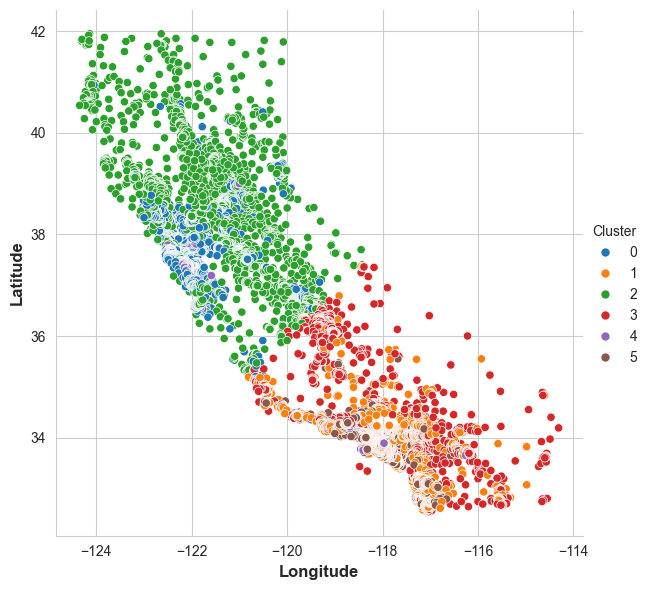

In [37]:
sns.scatterplot(
    data=X,
    x="Longitude", 
    y="Latitude", 
    hue="Cluster", 
    height=6,
);

The target in this dataset is MedHouseVal (median house value). These box-plots below show the distribution of the target within each cluster. If the clustering is informative, these distributions should, for the most part, separate across MedHouseVal, which is indeed what we see.

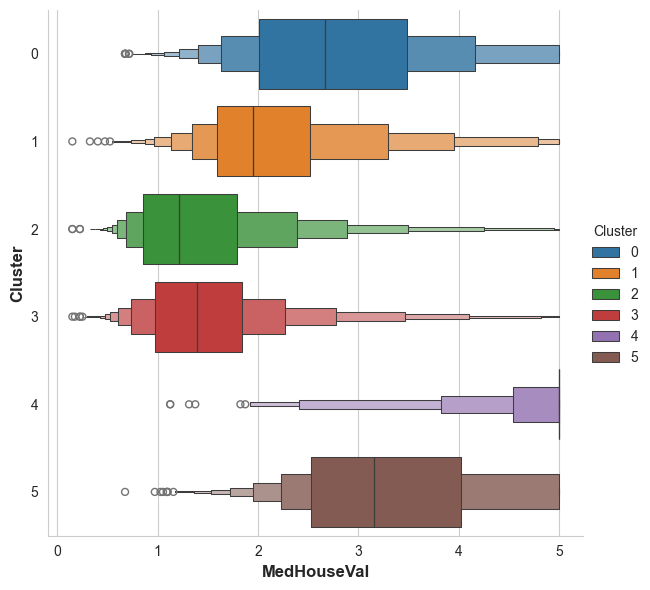

In [39]:
X["MedHouseVal"] = housing["MedHouseVal"]
sns.catplot(data=X, x="MedHouseVal", y="Cluster", kind="boxen", height=6, hue="Cluster", );

## Principal Component Analysis

### What is PCA?
It aims to transform a dataset consisting of possibly correlated variables (features) into a new set of uncorrelated variables called principal components.

### Creation of PCA
Creating PCA is simple. See code below:

In [59]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Sample data (replace X with your dataset)
X = pd.DataFrame(np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]))

print("\nX:")
display(X)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nX_scaled:")
display(X_scaled)

# Perform PCA
pca = PCA(n_components=2)  # Specify the number of components
X_pca = pca.fit_transform(X_scaled)

# The transformed dataset with PCA components
print("\nPCA Components:")
display(X_pca)


X:


,0,1,2
0,1,2,3
1,4,5,6
2,7,8,9



X_scaled:


array([[-1.22474487, -1.22474487, -1.22474487],
       [ 0.        ,  0.        ,  0.        ],
       [ 1.22474487,  1.22474487,  1.22474487]])


PCA Components:


array([[ 2.12132034,  0.        ],
       [-0.        ,  0.        ],
       [-2.12132034,  0.        ]])

### The main objectives of PCA

* **Dimensionality Reduction**: PCA reduces the number of dimensions (or features) in the dataset while preserving as much of the original information as possible.
* **Decorrelation**: PCA seeks to find a new set of variables that are orthogonal (uncorrelated) to each other, thus removing redundant information from the dataset.
* **Noise Reduction**: Principal components corresponding to low-variance dimensions often capture noise or irrelevant information in the data. By discarding these components, PCA can focus on the most informative dimensions, thereby reducing the impact of noise.
* **Visualization**: PCA can be used for data visualization by projecting high-dimensional data onto a lower-dimensional space (e.g., two or three dimensions). This allows for easier visualization and interpretation of the data.
* **Feature Extraction**: PCA can be used to identify the underlying structure and patterns in the data. The principal components represent new features that are combinations of the original variables, potentially revealing latent relationships or groupings in the data.

### PCA Best Practices
* PCA only works with numeric features, like continuous quantities or counts.
* PCA is sensitive to scale. It's good practice to `standardize` your data before applying PCA.
* Consider removing or constraining outliers, since they can have an undue influence on the results.

### Manual example
An abalone is a sea creature much like a clam or an oyster. We choose 2 features: the 'Height' and 'Diameter' of their shells.

![axes_of_variation](image/axes_of_variation.png)

Notice that instead of describing abalones by their 'Height' and 'Diameter', we could describe them by their 'Size' and 'Shape'. This, in fact, is the whole idea of PCA: instead of describing the data with the original features, we describe it with its variation. The variation become the new features.
![principal_components](image/principal_components.png)

The new features PCA constructs are actually just linear combinations (weighted sums) of the original features:
```javascript
df["Size"] = 0.707 * X["Height"] + 0.707 * X["Diameter"]
df["Shape"] = 0.707 * X["Height"] - 0.707 * X["Diameter"]
```

These new features are called the `principal components` of the data. The weights themselves are called `loadings`.

A component's loadings tell us what variation it expresses through signs and magnitudes:

| Features \ Components | Size (PC1)	| Shape (PC2)
| -------- | ------- |------- |
|Height	   |0.707	 |0.707   |
|Diameter  |0.707	 |-0.707  |


This table of loadings is telling us that in the `Size` component, `Height` and `Diameter` vary in the same direction (same sign), but in the `Shape` component they vary in opposite directions (opposite sign).

PCA also tells us the amount of variation in each component. 
![variance](image/variance.png)
`Size` accounts for about 96% and the `Shape` for about 4% of the variance between `Height` and `Diameter`.

Since the components tell you about the variation, you could compute the `MI scores` for the components and see what kind of variation is most predictive of your target. That could give you ideas for kinds of features to create -- a `product` of 'Height' and 'Diameter' if `'Size'` is important, say, or a `ratio` of 'Height' and 'Diameter' if `'Shape'` is important. 

### Example - 1985 Automobiles

Create `plot_variance()` and `make_mi_scores()` methods.

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler


sns.set_style("whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

Select a subset of autos dataframe (4 features) then standardize the data before applying PCA.

In [68]:
features = ["highway_mpg", "engine_size", "horsepower", "curb_weight"]

X = autos.copy()
y = X.pop('price')
X = X.loc[:, features]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Now we can fit scikit-learn's `PCA` estimator and create the principal components. You can see here the first few rows of the transformed dataset.

In [69]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)


# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4
0,0.383481,-0.401263,0.124444,0.169980
1,0.383481,-0.401263,0.124444,0.169980
2,1.554923,-0.107454,0.599917,-0.256747
3,-0.409923,-0.427055,0.243968,0.013956
4,1.135695,-0.816683,-0.203412,0.224721


After fitting, the PCA instance contains the loadings (weights) in its `components_` attribute. (Terminology for PCA is inconsistent, unfortunately. We're following the convention that calls the transformed columns in X_pca the components, which otherwise don't have a name.) We'll wrap the loadings up in a dataframe.

In [71]:
display(X.index)
display(X.columns)

RangeIndex(start=0, stop=193, step=1)

Index(['highway_mpg', 'engine_size', 'horsepower', 'curb_weight'], dtype='object')

In [72]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4
highway_mpg,-0.492347,0.770892,0.070142,-0.397996
engine_size,0.503859,0.626709,0.019960,0.594107
horsepower,0.500448,0.013788,0.731093,-0.463534
curb_weight,0.503262,0.113008,-0.678369,-0.523232


Recall that the signs and magnitudes of a component's loadings tell us what kind of variation it's captured. The first component (PC1) shows a contrast between large, powerful vehicles with poor gas milage, and smaller, more economical vehicles with good gas milage. We might call this the "Luxury/Economy" axis. The next figure shows that our four chosen features mostly vary along the Luxury/Economy axis.

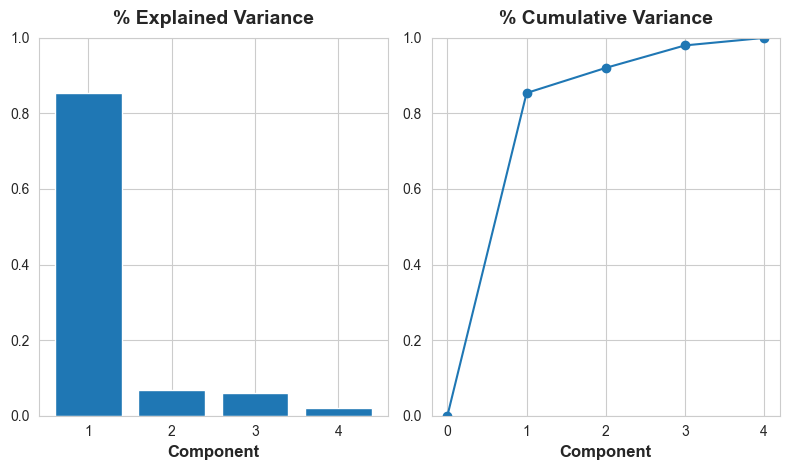

In [51]:
# Look at explained variance
plot_variance(pca);

Let's also look at the MI scores of the components. Not surprisingly, PC1 is highly informative, though the remaining components, despite their small variance, still have a significant relationship with price. Examining those components could be worthwhile to find relationships not captured by the main Luxury/Economy axis

In [52]:
mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
mi_scores

PC1    1.014022
PC2    0.379354
PC3    0.307251
PC4    0.205049
Name: MI Scores, dtype: float64

The third component shows a contrast between horsepower and curb_weight -- sports cars vs. wagons, it seems.

In [54]:
# Show dataframe sorted by PC3
idx = X_pca["PC3"].sort_values(ascending=False).index
cols = ["make", "body_style", "horsepower", "curb_weight"]
autos.loc[idx, cols]

,make,body_style,horsepower,curb_weight
118,porsche,hardtop,207,2756
117,porsche,hardtop,207,2756
119,porsche,convertible,207,2800
45,jaguar,sedan,262,3950
96,nissan,hatchback,200,3139
...,...,...,...,...
59,mercedes-benz,wagon,123,3750
61,mercedes-benz,sedan,123,3770
101,peugot,wagon,95,3430
105,peugot,wagon,95,3485


To express this contrast, let's create a new ratio feature:

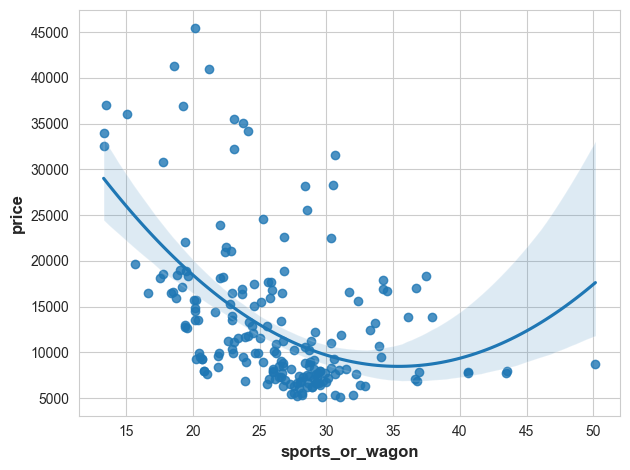

In [56]:
autos["sports_or_wagon"] = X.curb_weight / X.horsepower
sns.regplot(x="sports_or_wagon", y='price', data=autos, order=2);